In [1]:
# Cell 1: Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy import ndimage
from PIL import Image
import urllib.request
import io

plt.rcParams['figure.figsize'] = [12, 8]
np.set_printoptions(precision=4, suppress=True)

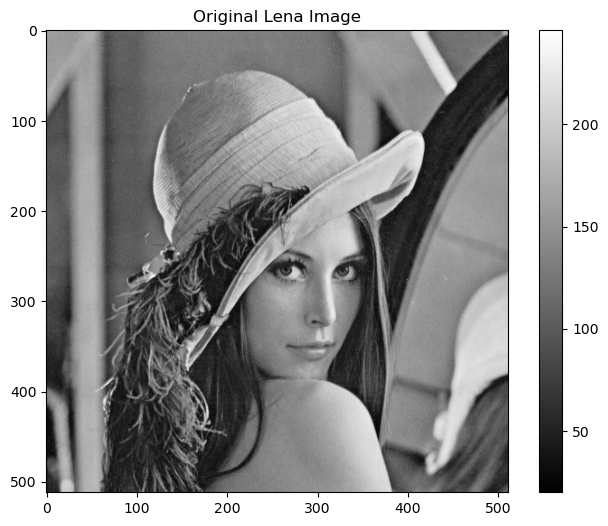

Image shape: (512, 512)
Image range: [20.0, 246.0]


In [3]:
# Cell 2: Download and load Lena image
def download_lena():
    url = "https://github.com/opencv/opencv/blob/master/samples/data/lena.jpg?raw=true"
    with urllib.request.urlopen(url) as response:
        image_data = response.read()
    
    image = Image.open(io.BytesIO(image_data))
    image = image.convert('L')  # Convert to grayscale
    image_array = np.array(image, dtype=np.float64)
    return image_array

original_image = download_lena()

plt.figure(figsize=(8, 6))
plt.imshow(original_image, cmap='gray')
plt.title('Original Lena Image')
plt.colorbar()
plt.show()

print(f"Image shape: {original_image.shape}")
print(f"Image range: [{original_image.min():.1f}, {original_image.max():.1f}]")

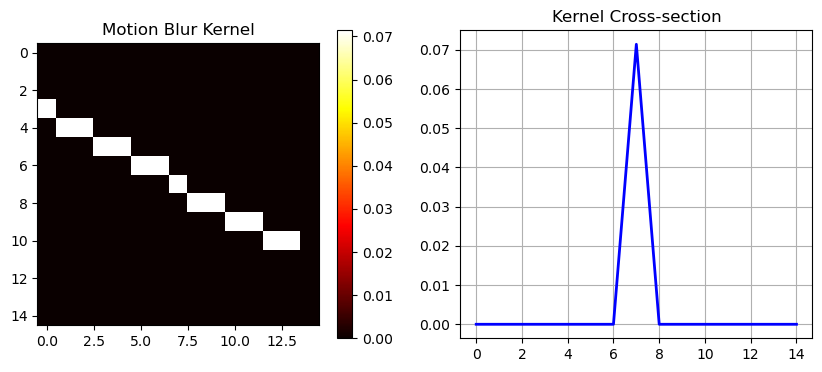

In [5]:
# Cell 3: Create degradation function (motion blur)
def create_motion_blur_kernel(size=15, angle=45):
    """Create a motion blur kernel"""
    kernel = np.zeros((size, size))
    center = size // 2
    
    # Create a line for motion blur
    angle_rad = np.deg2rad(angle)
    for i in range(size):
        x = int(center + (i - center) * np.cos(angle_rad))
        y = int(center + (i - center) * np.sin(angle_rad))
        if 0 <= x < size and 0 <= y < size:
            kernel[y, x] = 1.0
    
    # Normalize the kernel
    kernel = kernel / np.sum(kernel)
    return kernel

# Create blur kernel
blur_kernel = create_motion_blur_kernel(size=15, angle=30)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(blur_kernel, cmap='hot')
plt.title('Motion Blur Kernel')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.plot(blur_kernel[7, :], 'b-', linewidth=2)
plt.title('Kernel Cross-section')
plt.grid(True)
plt.show()

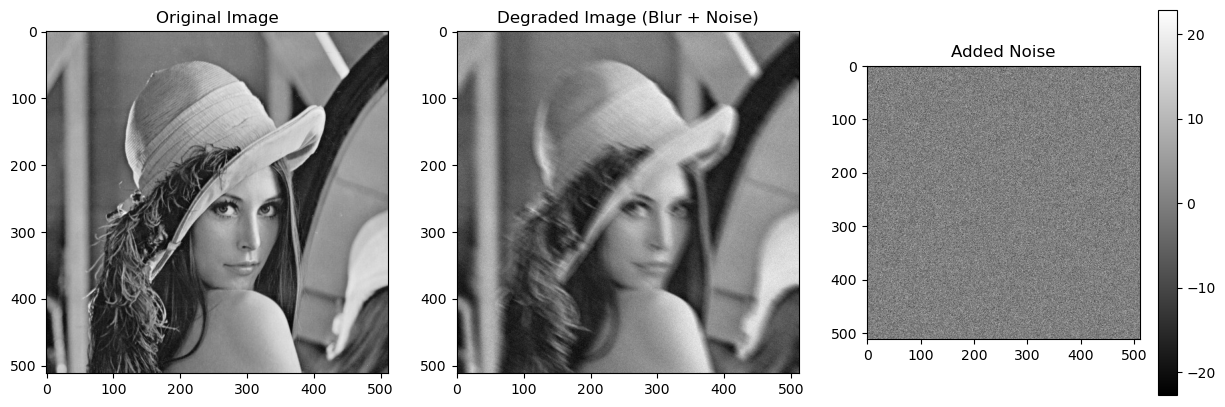

In [7]:
# Cell 4: Create degraded image (blur + noise)
def create_degraded_image(original, kernel, noise_level=0.01):
    """Apply blur and noise to create degraded image"""
    # Apply blur using convolution
    blurred = ndimage.convolve(original, kernel, mode='reflect')
    
    # Add Gaussian noise
    noise = np.random.normal(0, noise_level * original.max(), original.shape)
    degraded = blurred + noise
    
    # Clip to valid range
    degraded = np.clip(degraded, 0, 255)
    
    return degraded, noise

# Create degraded image
degraded_image, noise = create_degraded_image(original_image, blur_kernel, noise_level=0.02)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(degraded_image, cmap='gray')
plt.title('Degraded Image (Blur + Noise)')

plt.subplot(1, 3, 3)
plt.imshow(noise, cmap='gray')
plt.title('Added Noise')
plt.colorbar()
plt.show()

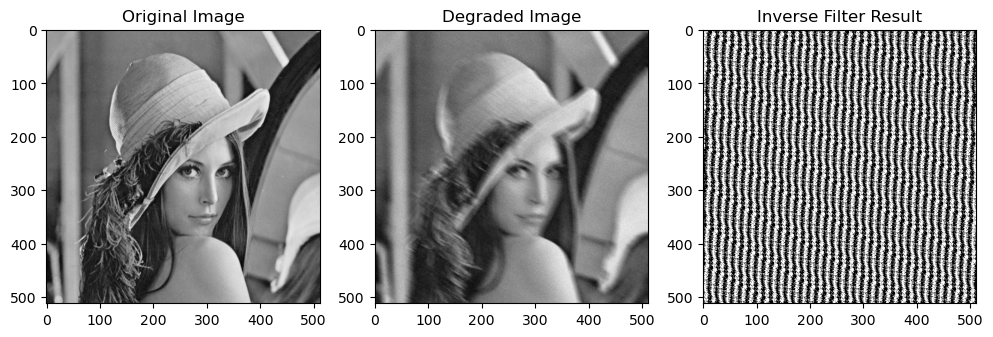

In [9]:
# Cell 5: Implement Inverse Filter
def inverse_filter(degraded, kernel):
    """Apply inverse filtering"""
    # Get dimensions
    M, N = degraded.shape
    kM, kN = kernel.shape
    
    # Pad kernel to match image size
    kernel_padded = np.zeros((M, N))
    kernel_padded[:kM, :kN] = kernel
    
    # Shift kernel to center for FFT
    kernel_padded = fftshift(kernel_padded)
    
    # Compute FFTs
    G = fft2(degraded)  # Degraded image FFT
    H = fft2(kernel_padded)  # Blur kernel FFT
    
    # Avoid division by zero - add small epsilon
    epsilon = 1e-8
    H_inv = 1 / (H + epsilon)
    
    # Apply inverse filter
    F_restored = G * H_inv
    
    # Inverse FFT and take real part
    restored = np.real(ifft2(F_restored))
    
    # Clip to valid range
    restored = np.clip(restored, 0, 255)
    
    return restored

# Apply inverse filter
inverse_restored = inverse_filter(degraded_image, blur_kernel)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(degraded_image, cmap='gray')
plt.title('Degraded Image')

plt.subplot(1, 3, 3)
plt.imshow(inverse_restored, cmap='gray')
plt.title('Inverse Filter Result')
plt.show()

In [11]:
# Cell 6: Implement Wiener Filter
def wiener_filter(degraded, kernel, K=0.01):
    """Apply Wiener filtering with noise-to-signal ratio K"""
    # Get dimensions
    M, N = degraded.shape
    kM, kN = kernel.shape
    
    # Pad kernel to match image size
    kernel_padded = np.zeros((M, N))
    kernel_padded[:kM, :kN] = kernel
    
    # Shift kernel to center for FFT
    kernel_padded = fftshift(kernel_padded)
    
    # Compute FFTs
    G = fft2(degraded)  # Degraded image FFT
    H = fft2(kernel_padded)  # Blur kernel FFT
    
    # Compute |H|²
    H_mag_sq = np.abs(H) ** 2
    
    # Wiener filter formula
    epsilon = 1e-8
    W = (H_mag_sq / (H_mag_sq + K)) / (H + epsilon)
    
    # Apply Wiener filter
    F_restored = G * W
    
    # Inverse FFT and take real part
    restored = np.real(ifft2(F_restored))
    
    # Clip to valid range
    restored = np.clip(restored, 0, 255)
    
    return restored

# Apply Wiener filter with different K values
wiener_restored_001 = wiener_filter(degraded_image, blur_kernel, K=0.01)
wiener_restored_01 = wiener_filter(degraded_image, blur_kernel, K=0.1)
wiener_restored_001

array([[38.8665, 56.5839, 30.0837, ..., 19.2349, 63.8277, 38.8568],
       [56.3072, 63.9023, 72.9309, ..., 51.1147,  0.    , 17.9182],
       [85.0779, 37.9689, 35.0563, ..., 58.7624, 50.8897, 81.6544],
       ...,
       [26.1094, 70.7379, 41.8398, ..., 60.7236, 26.3151, 74.96  ],
       [17.2733, 10.3261, 33.1542, ..., 36.8185,  0.    , 27.6093],
       [37.7789, 36.0017, 17.253 , ..., 10.4247, 56.7012, 48.7945]])

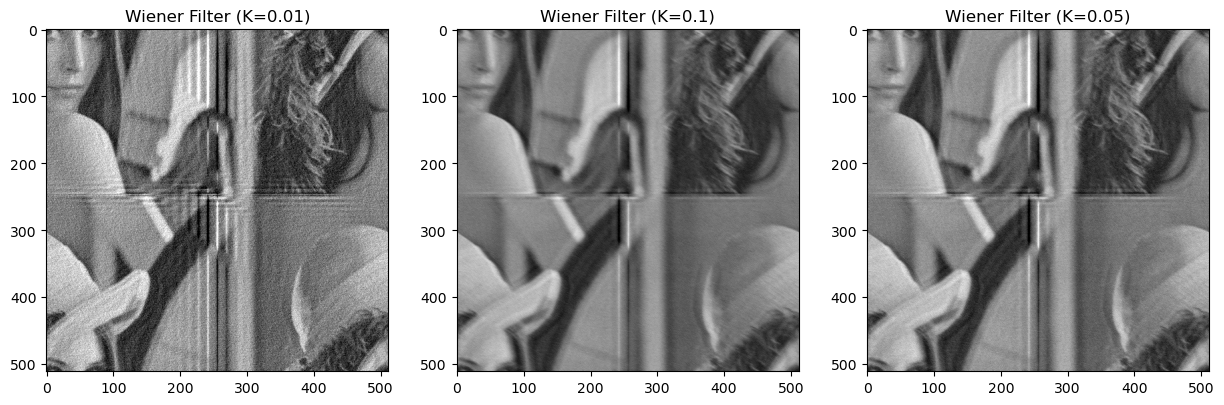

In [13]:
# Cell 7: Compare different K values for Wiener filter
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(wiener_restored_001, cmap='gray')
plt.title('Wiener Filter (K=0.01)')

plt.subplot(1, 3, 2)
plt.imshow(wiener_restored_01, cmap='gray')
plt.title('Wiener Filter (K=0.1)')

# Try another K value
wiener_restored_005 = wiener_filter(degraded_image, blur_kernel, K=0.05)
plt.subplot(1, 3, 3)
plt.imshow(wiener_restored_005, cmap='gray')
plt.title('Wiener Filter (K=0.05)')
plt.show()

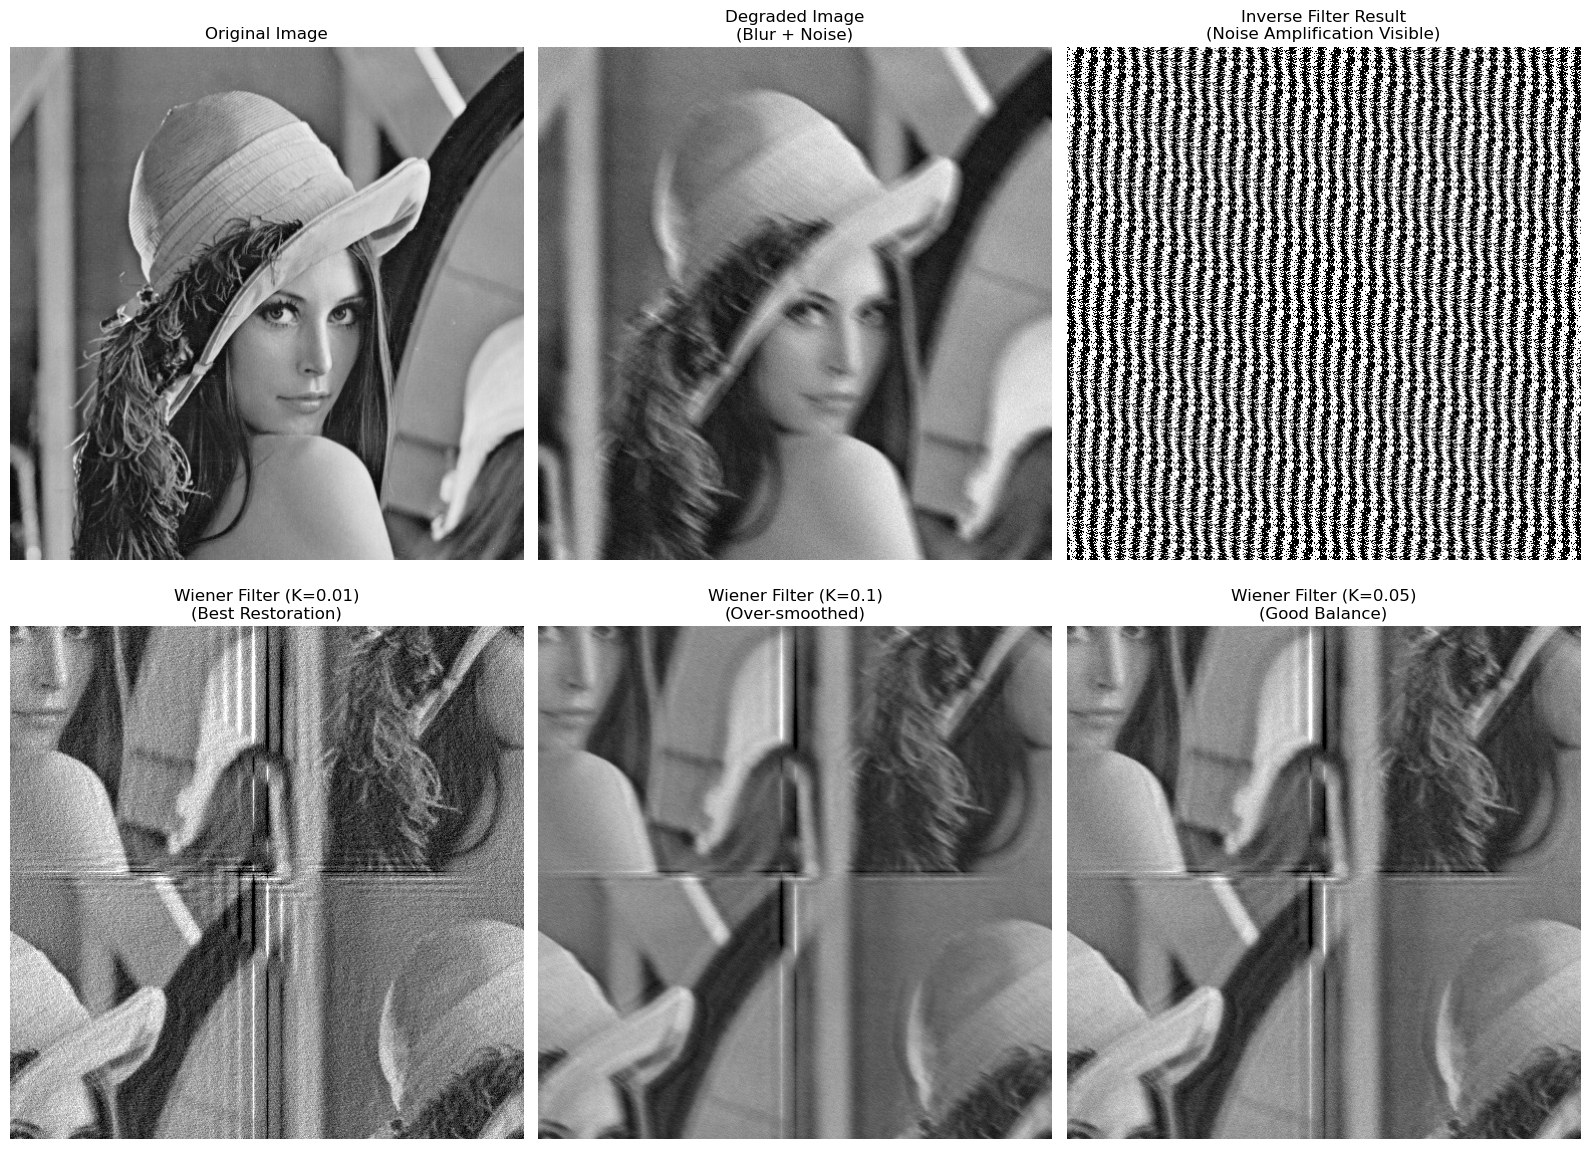

In [15]:
# Cell 8: Final comparison of all results
plt.figure(figsize=(16, 12))

plt.subplot(2, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(degraded_image, cmap='gray')
plt.title('Degraded Image\n(Blur + Noise)')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(inverse_restored, cmap='gray')
plt.title('Inverse Filter Result\n(Noise Amplification Visible)')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(wiener_restored_001, cmap='gray')
plt.title('Wiener Filter (K=0.01)\n(Best Restoration)')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(wiener_restored_01, cmap='gray')
plt.title('Wiener Filter (K=0.1)\n(Over-smoothed)')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(wiener_restored_005, cmap='gray')
plt.title('Wiener Filter (K=0.05)\n(Good Balance)')
plt.axis('off')

plt.tight_layout()
plt.show()